In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_data_template
from src.features.games import GameFeatures

In [3]:
data = load_data_template()
game_feat = GameFeatures(default_lags=3)
data = game_feat.per_team_wrapper(data, game_feat.last_games_won_in_season, fillna=0)
data = game_feat.per_team_wrapper(data, game_feat.last_games_won_in_tourney, fillna=0)
data = game_feat.per_team_wrapper(data, game_feat.last_games_won_against_opponent, fillna=0, per_game=True)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_tourney_against_opponent, fillna=0, per_game=True)
data.dropna(inplace=True)

In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss


X = data.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target', 'DayNum'], axis=1)
y = data[['a_win']].astype(int)

kf = KFold(n_splits=5, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X):
    X_tr, y_tr = X.iloc[tr_i], y.iloc[tr_i]
    X_t, y_t = X.iloc[t_i], y.iloc[t_i]
    xgb = XGBClassifier()
    xgb.fit(X_tr.values, y_tr.values.reshape(-1))
    preds = xgb.predict_proba(X_t.values)
    metric = log_loss(y_t.values, preds)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

0.29470268551058154
0.3145745087234866
0.3004908842380306
0.29429695717318877
0.32307263473230446
Metric Mean: 0.31 (0.01)


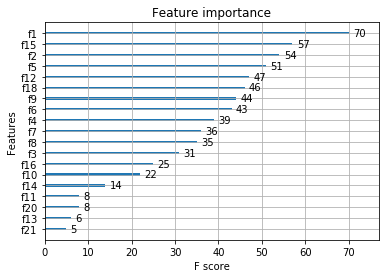

In [5]:
from xgboost import plot_importance

plt.figure(figsize=(20,8))
plot_importance(xgb, max_num_features=20)
plt.show()